In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore') 

In [2]:
def preprocess_data(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)

    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [3]:
train_data_path = 'Pneumonia_Dataset/train'
test_data_path = 'Pneumonia_Dataset/test'
valid_data_path = 'Pneumonia_Dataset/val'

In [4]:
train_df = preprocess_data(train_data_path)
test_df = preprocess_data(test_data_path)
valid_df = preprocess_data(valid_data_path)

In [5]:
train_df, dummy_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=42)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


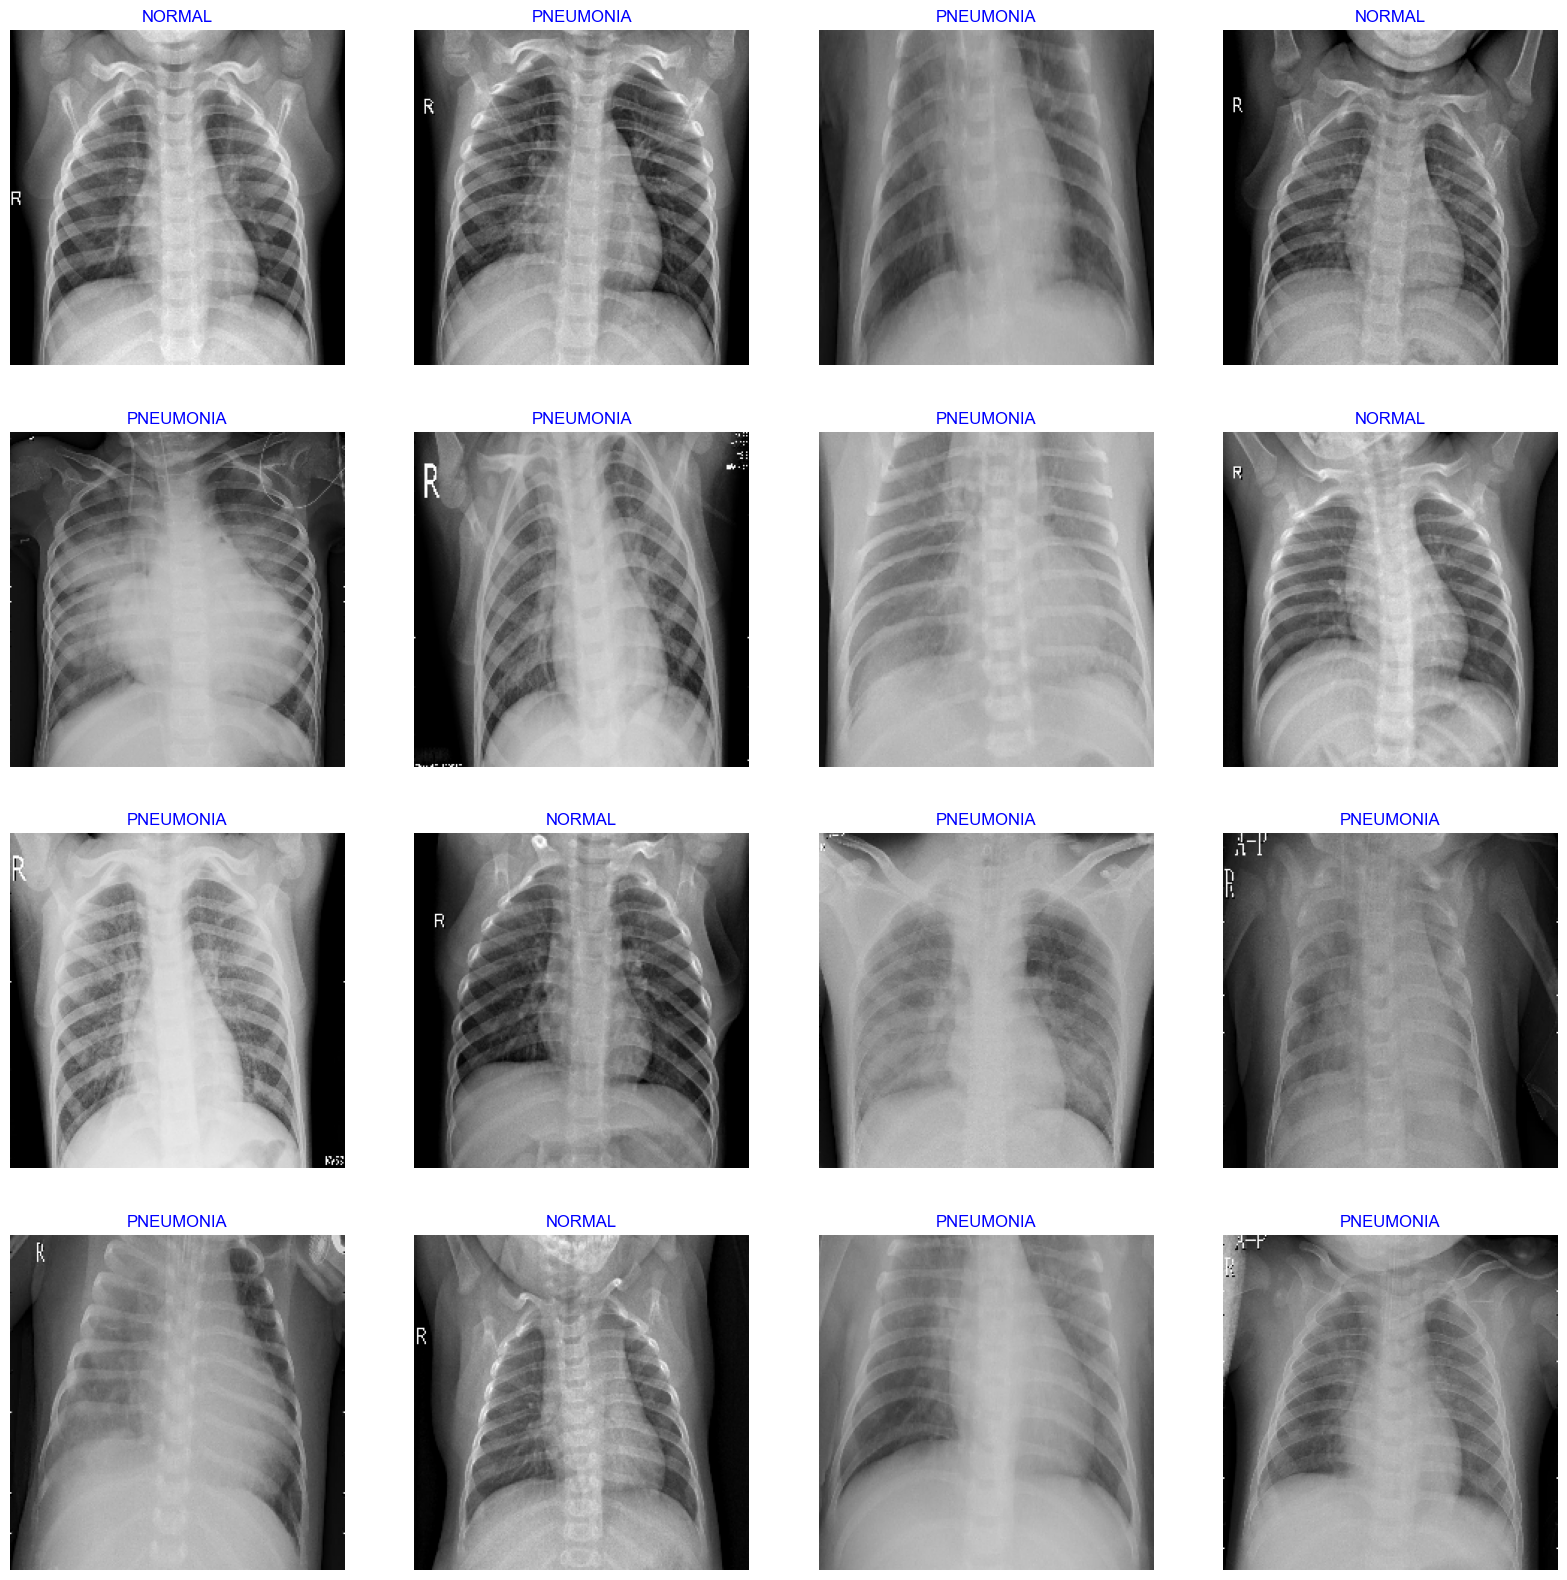

In [6]:
# Data Augmentation
img_size = (224, 224)
batch_size = 16
img_shape = (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [7]:
# Custom CNN Model
num_classes = len(train_df['label'].unique())

model = Sequential([
    Conv2D(32, (3, 3), input_shape=img_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.4),
    Dense(num_classes, activation='softmax')
])

In [8]:
# Model Compilation
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
Epochs = 10
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 622ms/step - accuracy: 0.7380 - loss: 21.1338 - val_accuracy: 0.9425 - val_loss: 0.1703
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 161s 617ms/step - accuracy: 0.9272 - loss: 0.1889 - val_accuracy: 0.9537 - val_loss: 0.1477
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 165s 631ms/step - accuracy: 0.9437 - loss: 0.1567 - val_accuracy: 0.9265 - val_loss: 0.1904
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 179s 684ms/step - accuracy: 0.9323 - loss: 0.1652 - val_accuracy: 0.9217 - val_loss: 0.1887
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 639ms/step - accuracy: 0.9423 - loss: 0.1512 - val_accuracy: 0.9681 - val_loss: 0.0862
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 168s 645ms/step - accuracy: 0.9593 - loss: 0.1054 - val_accuracy: 0.9441 - val_loss: 0.1645
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 164s 628ms/step - accuracy: 0.9524 - loss: 0.1291 - val_accuracy: 0.9665 - val_loss: 0.0965
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 157s 600ms/step - accuracy: 0.9575 

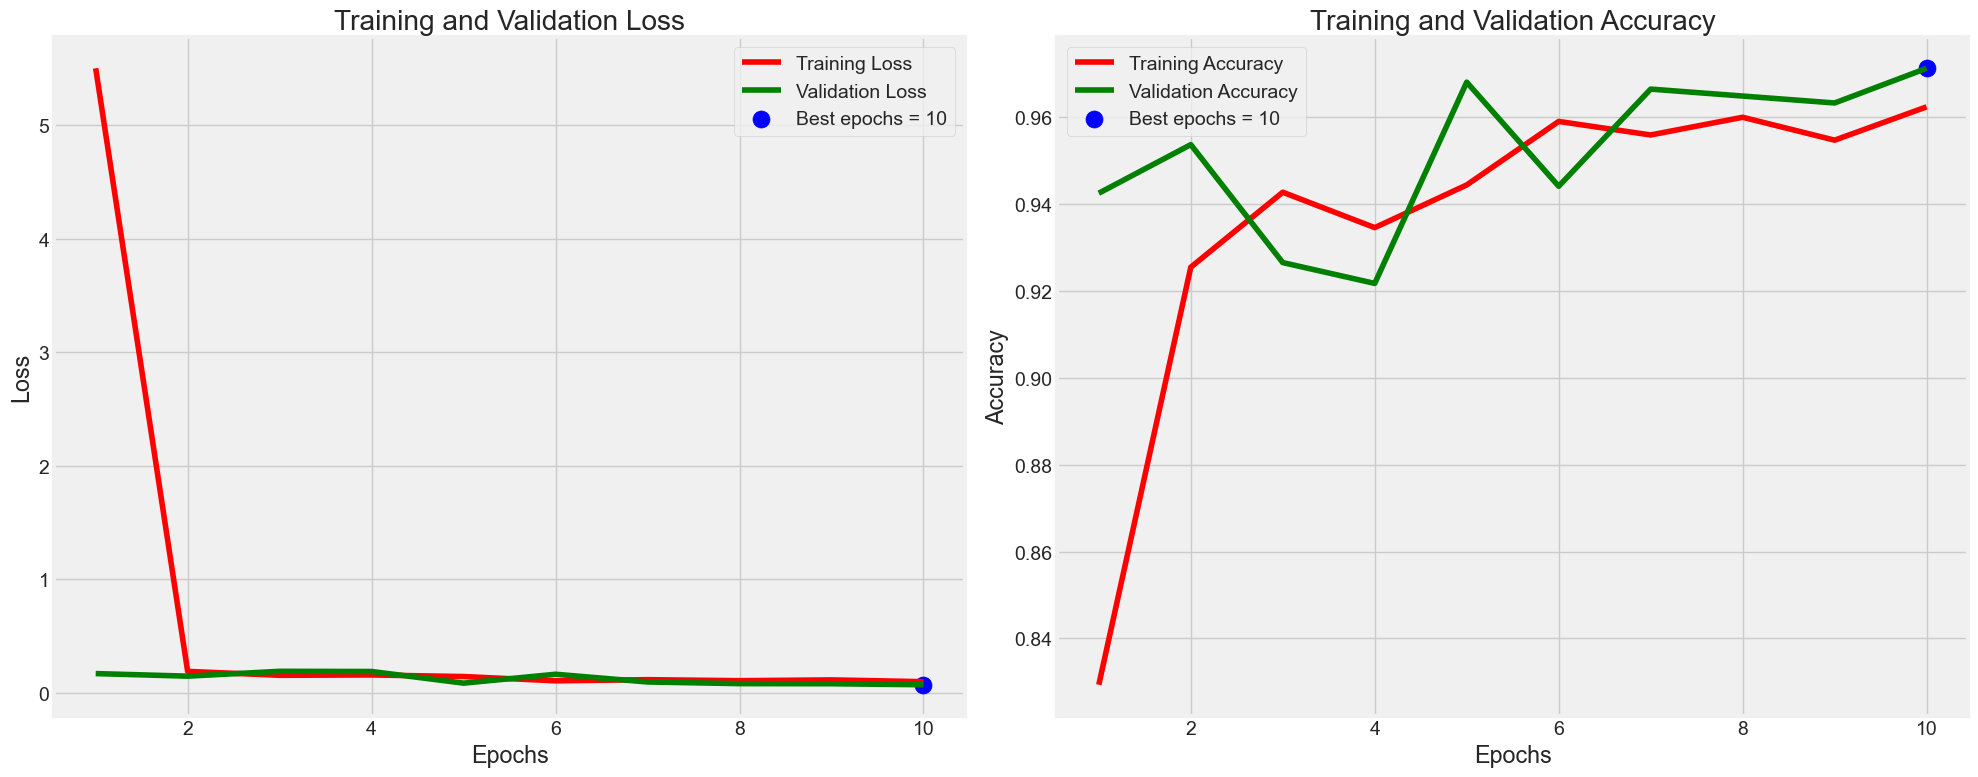

In [10]:
# Training history
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss + 1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show();

In [11]:
# Model Evaluation
train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9865 - loss: 0.0395
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9768 - loss: 0.0641
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.9848 - loss: 0.0403
Train Loss:  0.04420517012476921
Train Accuracy:  0.984375
--------------------
Validation Loss:  0.06622287631034851
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.05095724016427994
Test Accuracy:  0.9765625


In [12]:
# Calculate Recall, Precision, and F1 Score
test_preds = model.predict(test_gen)
test_preds = np.argmax(test_preds, axis=1)
test_labels = test_gen.labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step


In [17]:
all_classes = np.arange(len(classes))
cm = confusion_matrix(test_labels, test_preds)

In [18]:
# Recall, Precision, and F1 Score for each class
recall = recall_score(test_labels, test_preds, average=None)
precision = precision_score(test_labels, test_preds, average=None)
f1 = f1_score(test_labels, test_preds, average=None)

print("Recall for each class:")
for i, c in enumerate(classes):
    print(f"{c}: {recall[i]}")

print("Precision for each class:")
for i, c in enumerate(classes):
    print(f"{c}: {precision[i]}")

print("F1 Score for each class:")
for i, c in enumerate(classes):
    print(f"{c}: {f1[i]}")

Recall for each class:
NORMAL: 0.9813084112149533
PNEUMONIA: 0.9517684887459807
Precision for each class:
NORMAL: 0.875
PNEUMONIA: 0.9932885906040269
F1 Score for each class:
NORMAL: 0.9251101321585904
PNEUMONIA: 0.9720853858784894


In [19]:
# Display Classification Report
print(classification_report(test_labels, test_preds, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.88      0.98      0.93       107
   PNEUMONIA       0.99      0.95      0.97       311

    accuracy                           0.96       418
   macro avg       0.93      0.97      0.95       418
weighted avg       0.96      0.96      0.96       418



27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step


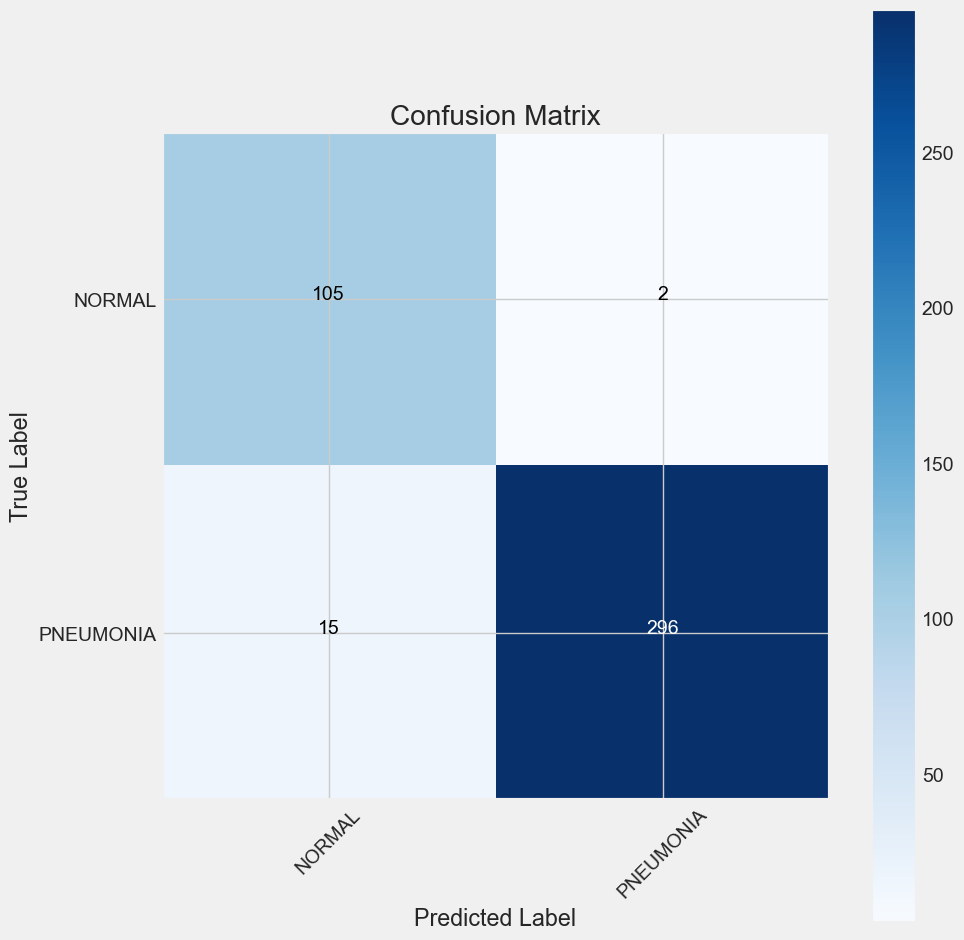

In [44]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()